In [382]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import json
%matplotlib inline

import networkx.algorithms.community as nxcom

## Generating Graphs

In [308]:
# Reading data

file_path = "../Data/climate_top_100_anon_reply_retweet.txt"

with open(file_path) as f:
    raw = f.readlines()

f.close()

In [309]:
# Converting string representation to retweet/reply dictionaries

def convert(raw):
    data = []
    for line in raw:
        clean_line = json.loads(line)
        data.append(clean_line)

    retweets = {}
    replies = {}
    for row in data:
        retweets[row[0]] = row[1]
        replies[row[0]] = row[2]

    return retweets, replies

In [310]:
retweets, replies = convert(raw)

In [311]:
def remove_noncore(data):
    for key in data:
        data[key][:] = [x for x in data[key] if x < 10000]
    return data

In [312]:
%%time
retweets_core = remove_noncore(retweets)
replies_core = remove_noncore(replies)

CPU times: user 486 ms, sys: 12 ms, total: 498 ms
Wall time: 497 ms


In [8]:
G_core = nx.from_dict_of_lists(retweets_core)

In [9]:
H_core = nx.from_dict_of_lists(replies_core)

In [13]:
layout = nx.spring_layout(G_core)
L = G_core.number_of_edges()
N = G_core.number_of_nodes()

In [409]:
def partToList(part):
    '''Print partition as a list'''
    N=0
    for b in range(len(part)):
        N=N+len(part[b])
    listP=np.zeros(N)
    for b in range(len(part)):
        for n in part[b]:
            listP[n-1]=b
            
    return(listP)

In [11]:
# Function: Check if nodes share an edge
def nodes_connected(G, u, v):
    return u in G.neighbors(v)

0.2974959829700293
CPU times: user 1min 31s, sys: 211 ms, total: 1min 31s
Wall time: 1min 31s


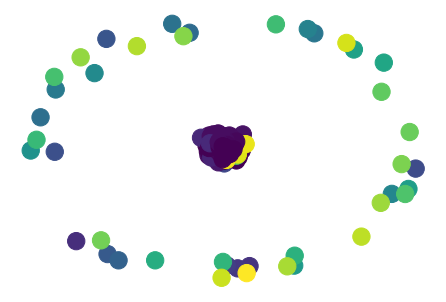

In [14]:
%%time
partGreedy = nxcom.greedy_modularity_communities(G_core)
print(nxcom.modularity(G_core,partGreedy))
nx.draw(G_core,pos=layout,node_color=partToList(partGreedy))

In [24]:
print("Number of communities:", len(partGreedy))

Number of communities: 62


0.24309613826525964
CPU times: user 1min 12s, sys: 272 ms, total: 1min 13s
Wall time: 1min 12s


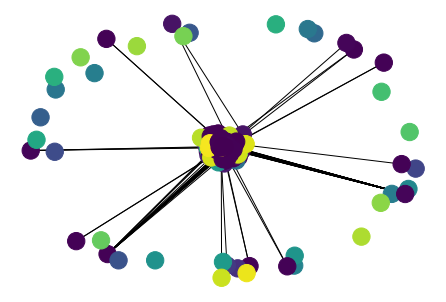

In [25]:
%%time
partGreedy = nxcom.greedy_modularity_communities(H_core)
print(nxcom.modularity(G_core,partGreedy))
nx.draw(H_core,pos=layout,node_color=partToList(partGreedy))

In [26]:
print("Number of communities:", len(partGreedy))

Number of communities: 166


## Retweet Network

### Examining Greatest Component

In [27]:
largest_cc=max(nx.connected_components(G_core),key=len)
Gcc=G_core.subgraph(largest_cc)
Gcc.number_of_nodes()

4029

In [28]:
layout = nx.spring_layout(Gcc)

In [29]:
%%time
partGreedy_gcc = nxcom.greedy_modularity_communities(Gcc)
mod = nxcom.modularity(Gcc, partGreedy_gcc)
print(mod)
# nx.draw(Gcc, pos=layout,node_color=partToList(partGreedy_gcc))

0.29746459204985515
CPU times: user 1min 34s, sys: 264 ms, total: 1min 35s
Wall time: 1min 35s


In [30]:
print("Number of communities:", len(partGreedy_gcc))

Number of communities: 20


In [31]:
# Renumbering to plot correct colours for communities in nx.draw()
def renumber(partition):
    lst = []
    i = 0
    for fset in partition:
        element = []
        for node in fset:
            element.append(i)
            i += 1
        lst.append(element)
        
    return lst

In [32]:
%%time
pos = nx.spring_layout(Gcc, k=0.05)

CPU times: user 1min 19s, sys: 31.3 ms, total: 1min 19s
Wall time: 1min 19s


CPU times: user 6.41 s, sys: 280 ms, total: 6.69 s
Wall time: 6.32 s


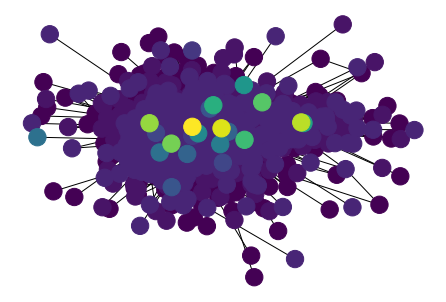

In [33]:
%%time
ren_partGreedy_gcc = renumber(partGreedy_gcc)
nx.draw(Gcc, pos = pos, node_color=partToList(ren_partGreedy_gcc))

CPU times: user 6.76 s, sys: 345 ms, total: 7.1 s
Wall time: 6.76 s


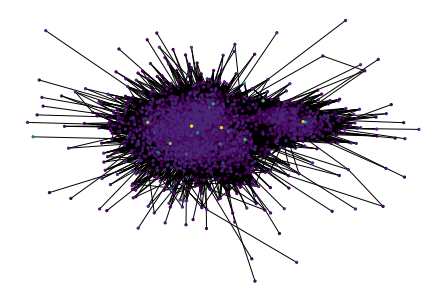

In [34]:
%%time
nx.draw(Gcc, pos = pos, node_size = 5, node_color=partToList(ren_partGreedy_gcc))

### Checking neighbors of size 1 communities

When checking the second layer, the number of connections increased significantly.

In [140]:
# Storing nodes two layers up from size 1 communities
outer_nodes = []
for comm in partGreedy_gcc:
    if len(comm) == 1:
        comm = list(comm)
        print(comm)
        for neighbor in Gcc.neighbors(comm[0]):
            outer_nodes.append(neighbor)
            print("\t", neighbor)

[974]
	 83
	 284
	 1735
	 974
[986]
	 971
	 986
[1251]
	 1251
	 1279
[1420]
	 232
	 1420
	 2543
[2130]
	 58
	 2130
	 3753
[2348]
	 2409
	 2348
[2402]
	 1078
	 2221
	 2402
	 3331
[2584]
	 2584
	 1371
	 202
	 3273
[3167]
	 3167
	 1315
[3873]
	 3873
	 1315
[3888]
	 3888
	 4020
[3932]
	 3932
	 1755


## Removing Self-Loops

In [35]:
nos_Gcc = Gcc.copy()

In [36]:
nos_Gcc.remove_edges_from(nx.selfloop_edges(nos_Gcc))

In [37]:
partGreedy_nos_gcc = nxcom.greedy_modularity_communities(nos_Gcc)
mod = nxcom.modularity(nos_Gcc, partGreedy_nos_gcc)
print(mod)

0.29531660018861366


CPU times: user 4.46 s, sys: 257 ms, total: 4.72 s
Wall time: 4.4 s


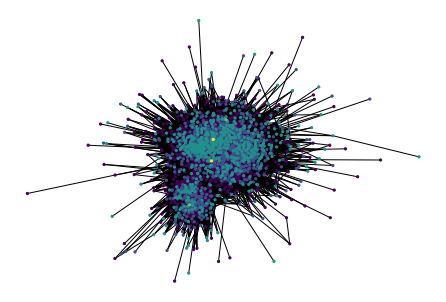

In [121]:
%%time
ren_partGreedy_nos_gcc = renumber(partGreedy_nos_gcc)
nx.draw(nos_Gcc, pos=pos, node_size = 5, node_color=partToList(ren_partGreedy_nos_gcc))

CPU times: user 19.7 s, sys: 8.31 s, total: 28.1 s
Wall time: 14.5 s


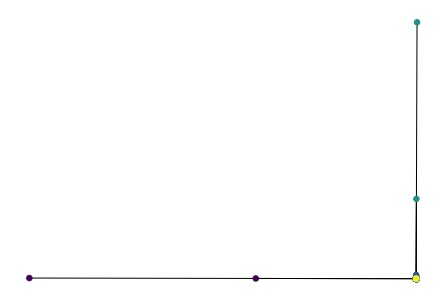

In [142]:
%%time
ren_partGreedy_nos_gcc = renumber(partGreedy_nos_gcc)
nx.draw_spectral(nos_Gcc, node_size = 30, node_color=partToList(ren_partGreedy_nos_gcc))

In [38]:
print("Number of communities:", len(partGreedy_nos_gcc))

Number of communities: 5


In [39]:
print("Sizes of communities:")
for i in partGreedy_nos_gcc:
    print(len(i))

Sizes of communities:
2468
953
604
2
2


We observe that the communites of size 1 disappear when self-loops are removed from the network, i.e. self-retweets and self-replies. This could be applied as a method to detect bots, as potentially fewer users would retweet other bots.

In [78]:
# Checking if modularity increases when combining any of the communities of size 1 with a large community

bool_list = []
k = 8
while k < 19:
    j = 0
    while j < 3:
        new_set = []
        for n, i in enumerate(partGreedy_gcc):
            if n == k:
                new_set[j].extend(list(i))
            else:
                new_set.append(list(i))
        bool_list.append(mod < nxcom.modularity(Gcc, new_set))
        j += 1
    k += 1

In [80]:
print(any(bool_list))

False


## Reply Network

In [40]:
largest_cc=max(nx.connected_components(H_core),key=len)
Hcc=H_core.subgraph(largest_cc)
Hcc.number_of_nodes()

3954

In [41]:
%%time
partGreedy_hcc = nxcom.greedy_modularity_communities(Hcc)
mod = nxcom.modularity(Hcc, partGreedy_hcc)
print(mod)

0.2715354617878591
CPU times: user 1min 11s, sys: 120 ms, total: 1min 11s
Wall time: 1min 11s


CPU times: user 1min 13s, sys: 292 ms, total: 1min 13s
Wall time: 1min 13s


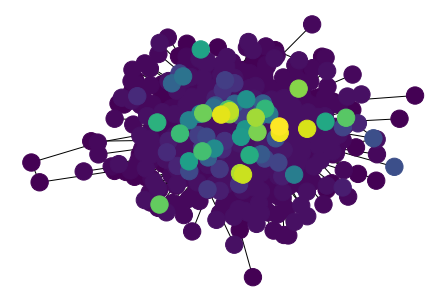

In [42]:
%%time
ren_partGreedy_hcc = renumber(partGreedy_hcc)
nx.draw(Hcc, node_color=partToList(ren_partGreedy_hcc))

In [43]:
print("Number of communities:", len(partGreedy_hcc))

Number of communities: 51


In [ ]:
# Storing nodes two layers up from size 1 communities
outer_nodes = []
for comm in partGreedy_hcc:
    if len(comm) == 1:
        comm = list(comm)
        print(comm)
        for neighbor in Hcc.neighbors(comm[0]):
            outer_nodes.append(neighbor)
            print("\t", neighbor)

## Removing Self-loops

In [44]:
nos_Hcc = Hcc.copy()

In [45]:
nos_Hcc.remove_edges_from(nx.selfloop_edges(nos_Hcc))

In [46]:
partGreedy_nos_hcc = nxcom.greedy_modularity_communities(nos_Hcc)
mod = nxcom.modularity(nos_Hcc, partGreedy_nos_hcc)
print(mod)

0.26446031114365337


CPU times: user 1min 10s, sys: 186 ms, total: 1min 11s
Wall time: 1min 10s


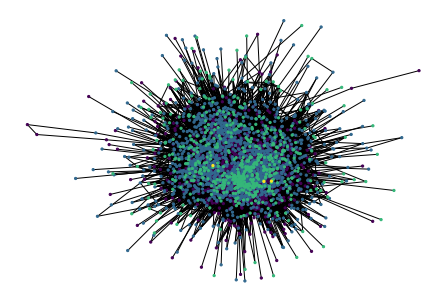

In [158]:
%%time
ren_partGreedy_nos_hcc = renumber(partGreedy_nos_hcc)
nx.draw(nos_Hcc, node_size = 5, node_color=partToList(ren_partGreedy_nos_hcc))

In [47]:
print("Number of communities:", len(partGreedy_nos_hcc))

Number of communities: 4


In [48]:
print("Sizes of communities:")
for i in partGreedy_nos_hcc:
    print(len(i))

Sizes of communities:
1761
1631
559
3


In [49]:
# Finding number of users that share the same retweet and reply network
common = {}
for i, comm in enumerate(partGreedy_nos_hcc):
    common[i] = []
    for comm2 in partGreedy_nos_gcc:
        counter = 0
        for user in comm:
            if user in comm2:
                counter += 1
        common[i].append(counter)

$4 \times 5$ matrix where each element $a_{ij}$ is the number of common users between the $i$-th community of the reply network and $j$-th community of the retweet network, ordered by size

In [50]:
common

{0: [1372, 367, 18, 2, 0],
 1: [982, 71, 569, 0, 1],
 2: [33, 513, 10, 0, 0],
 3: [2, 0, 0, 0, 0]}

## Exporting data

In [51]:
import pandas as pd

In [54]:
retweet_nodes = sorted(nos_Gcc.degree, key=lambda x: x[1], reverse=True)

In [55]:
reply_nodes = sorted(nos_Hcc.degree, key=lambda x: x[1], reverse=True)

In [57]:
len(retweet_nodes)

4029

In [159]:
len(reply_nodes)

3954

In [292]:
nodes = pd.DataFrame(columns = ['User', 'Retweet Degree', 'Reply Degree', 'Retweet Community', 'Reply Community'])

In [293]:
for i, row in enumerate(retweet_nodes):
    row = list(row)
    row.extend([np.NaN, np.NaN, np.NaN])
    nodes.loc[i] = row

In [294]:
nodes = nodes.set_index('User')

In [295]:
for row in reply_nodes:
    row = list(row)
    if float(row[0]) in nodes.index:
        nodes.loc[row[0]][1] = row[1]

In [296]:
nodes = nodes.dropna(subset = ['Reply Degree'])

In [297]:
for i, users in enumerate(partGreedy_nos_gcc):
    for user in users:
        if user in nodes.index:
            nodes.loc[user]['Retweet Community'] = i
            
for i, users in enumerate(partGreedy_nos_hcc):
    for user in users:
        if user in nodes.index:
            nodes.loc[user]['Reply Community'] = i

In [298]:
nodes.index = nodes.index.astype(int)
nodes = nodes.astype(int)

In [302]:
nodes.to_csv("node_degree.csv", 
           index=True)

## Directed Graph

In [345]:
G_core_di = nx.from_dict_of_lists(retweets_core, create_using = nx.DiGraph)
H_core_di = nx.from_dict_of_lists(replies_core, create_using = nx.DiGraph)

In [347]:
print(len(G_core_di.edges()))
print(len(H_core_di.edges()))

431592
236864


In [352]:
def remove_edges(graph):
    """
    Removes edges that do not have an opposite pair. Preserves reciprocal connections
    """
    remove = []
    for e in graph.edges():
        j = e[::-1]
        if j not in graph.edges():
            remove.append(e)
    
    for e in remove:
        graph.remove_edge(*e)

In [353]:
remove_edges(G_core_di)
remove_edges(H_core_di)

In [354]:
print(len(G_core_di.edges()))
print(len(H_core_di.edges()))

68339
51378


In [359]:
G_core_di = G_core_di.to_undirected()
H_core_di = H_core_di.to_undirected()

In [364]:
def greedy_modularity(G):
    """
    Returns partition of graph using greedy modularity algorithm
    """
    largest_cc=max(nx.connected_components(G), key=len)
    Gcc=G.subgraph(largest_cc)
    
    partGreedy_gcc = nxcom.greedy_modularity_communities(Gcc)

    return Gcc, partGreedy_gcc

In [365]:
Gcc_di, partGreedy_Gcore_di = greedy_modularity(G_core_di)

mod = nxcom.modularity(Gcc_di, partGreedy_Gcore_di)
print(mod)

0.5536326634124624


In [367]:
print(len(partGreedy_Gcore_di))

88


In [366]:
Hcc_di, partGreedy_Hcore_di = greedy_modularity(H_core_di)

mod = nxcom.modularity(Hcc_di, partGreedy_Hcore_di)
print(mod)

0.5042757509303476


In [368]:
print(len(partGreedy_Hcore_di))

160


### Removing self-loops

In [371]:
nos_Gcc_di = Gcc_di.copy()
nos_Gcc_di.remove_edges_from(nx.selfloop_edges(nos_Gcc_di))

In [372]:
partGreedy_nos_Gcc_di = nxcom.greedy_modularity_communities(nos_Gcc_di)
mod = nxcom.modularity(nos_Gcc_di, partGreedy_nos_Gcc_di)
print(mod)

0.5161429809543705


In [373]:
print(len(partGreedy_nos_Gcc_di))

11


In [374]:
for i in partGreedy_nos_Gcc_di:
    print(len(i))

1210
1069
602
193
33
8
6
3
3
2
2


In [375]:
nos_Hcc_di = Hcc_di.copy()
nos_Hcc_di.remove_edges_from(nx.selfloop_edges(nos_Hcc_di))

In [376]:
partGreedy_nos_Hcc_di = nxcom.greedy_modularity_communities(nos_Hcc_di)
mod = nxcom.modularity(nos_Hcc_di, partGreedy_nos_Hcc_di)
print(mod)

0.4059452705477205


In [378]:
print(len(partGreedy_nos_Hcc_di))

37


In [377]:
for i in partGreedy_nos_Hcc_di:
    print(len(i))

1050
1042
321
197
53
10
9
7
7
7
6
6
5
5
4
4
4
3
3
3
3
3
3
3
3
3
3
2
2
2
2
2
2
2
2
2
2


In [379]:
common = {}
for i, comm in enumerate(partGreedy_nos_Hcc_di):
    common[i] = []
    for comm2 in partGreedy_nos_Gcc_di:
        counter = 0
        for user in comm:
            if user in comm2:
                counter += 1
        common[i].append(counter)

In [380]:
common

{0: [39, 435, 501, 3, 0, 0, 1, 0, 0, 1, 0],
 1: [810, 132, 26, 11, 0, 6, 0, 0, 0, 0, 0],
 2: [6, 253, 24, 2, 0, 0, 0, 0, 0, 0, 0],
 3: [16, 47, 0, 95, 5, 0, 0, 0, 0, 0, 0],
 4: [28, 8, 11, 0, 0, 1, 0, 0, 0, 0, 0],
 5: [0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 6: [2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 7: [0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 8: [2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 9: [2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 10: [0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0],
 11: [0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0],
 12: [4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 13: [2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
 14: [3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 15: [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 16: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 17: [2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 18: [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 19: [0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0],
 20: [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 21: [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
 22: [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 23: [0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 24: [0, 0, 2, 0, 0, 0, 0, 0, 0

### Clustering Coefficient

In [58]:
retweet_core_coeff = cluster.average_clustering(G_core)

In [59]:
reply_core_coeff = cluster.average_clustering(H_core)

In [60]:
print("Retweets: {:2.2%}".format(retweet_core_coeff))
print("Replies: {:2.2%}".format(reply_core_coeff))

Retweets: 29.28%
Replies: 18.97%


## Drawing simple graph
Demonstrating behaviour of nodes with self-loops, with equal connections to other communities

In [384]:
G = nx.Graph()

In [387]:
G.add_nodes_from([1,2,3,4])

In [435]:
G.add_edges_from([(1,2), (2,3),(3,4), (1,4), (2,4), (1,3)])

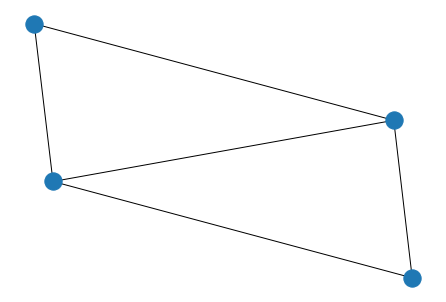

In [389]:
nx.draw(G)

In [390]:
G.add_nodes_from([5,6,7,8])

In [434]:
G.add_edges_from([(5,6), (6,7),(7,8), (5,8), (6,8), (5, 7)])

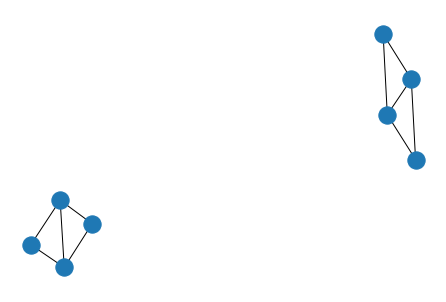

In [392]:
nx.draw(G)

In [444]:
G.remove_edge(1,5)

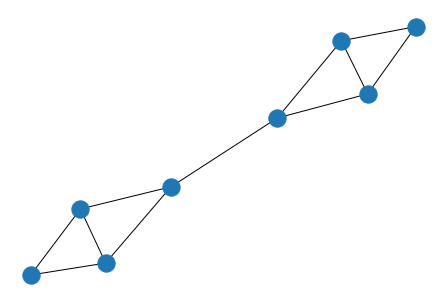

In [397]:
layout = nx.spring_layout(G)
nx.draw(G, pos = layout)

In [398]:
partGreedy = nxcom.greedy_modularity_communities(G)
mod = nxcom.modularity(G, partGreedy)
print(mod)

0.40909090909090906


In [399]:
partGreedy

[frozenset({1, 2, 3, 4}), frozenset({5, 6, 7, 8})]

In [ ]:
G.add_node(9)

In [423]:
G.add_edges_from([(2, 9), (6, 9)])

In [468]:
partGreedy_nos = nxcom.greedy_modularity_communities(G)
mod = nxcom.modularity(G, partGreedy_nos)
print(mod)

0.42602040816326536


When there is no self-loop, we observe that the middle node gets joined to a community. Since, this is a maximisation problem, the community chosen is the first one.

In [469]:
partGreedy_nos

[frozenset({1, 2, 3, 4, 9}), frozenset({5, 6, 7, 8})]

In [470]:
G.add_edge(9,9)

In [471]:
partGreedy = nxcom.greedy_modularity_communities(G)
mod = nxcom.modularity(G, partGreedy)
print(mod)

0.4733333333333334


When adding a self-loop, on the middle node, the third community emerges.

In [472]:
partGreedy

[frozenset({1, 2, 3, 4}), frozenset({5, 6, 7, 8}), frozenset({9})]

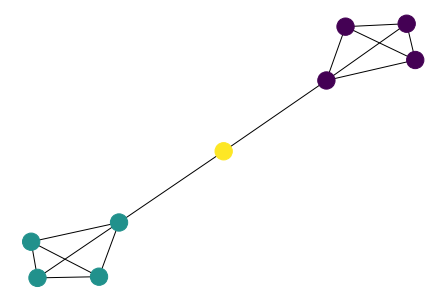

In [476]:
layout = nx.spring_layout(G)
nx.draw(G, pos = layout, node_color=partToList(partGreedy))

In [474]:
mod = nxcom.modularity(G, partGreedy_nos)
print(f'No self-loop: {mod:.3f}')
mod = nxcom.modularity(G, partGreedy)
print(f'With self-loop: {mod:.3f}')

No self-loop: 0.424
With self-loop: 0.473
